In [1]:
# SimpleWPGen_Strip
# Ren Cooper, LBNL
# Gamma-Ray Tracking School, ORNL, October 2018
#
# very simple Weighting Potential solver for a single strip of a HPGe detector via SOR method
#  - Disclaimer: for demonstration/example purposes only!
#
# also includes a very crude example of signal generation


In [373]:
%matplotlib inline
%reset -f

In [374]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

In [375]:
# import drift velocities
filename = './drift_velocities.txt'
drift_velocity_table = np.genfromtxt(filename, comments='#', delimiter=None)
#print(drift_velocity_table)
#print(drift_velocity_table[:,0])
E_vals = drift_velocity_table[:,0]
e_vals = drift_velocity_table[:,1]
h_vals = drift_velocity_table[:,4]

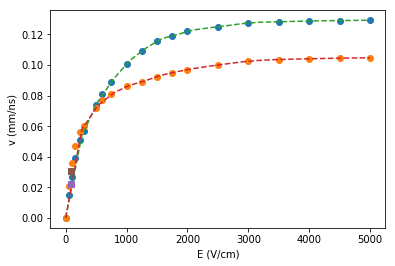

In [403]:
E_func = np.linspace(0, 5000, 20)  # V/cm
efunc = interp1d(E_vals, e_vals, kind='cubic')
hfunc = interp1d(E_vals, h_vals, kind='cubic')

plt.plot(E_vals, e_vals,'o')
plt.plot(E_vals, h_vals,'o')
plt.plot(E_func,efunc(E_func),'--' )
plt.plot(E_func,hfunc(E_func),'--' )
plt.plot(80,efunc(80),'s' )
plt.plot(80,hfunc(80),'s' )
plt.plot()
plt.ylabel('v (mm/ns)')
plt.xlabel('E (V/cm)')
plt.show()

In [404]:
# set some detector parameters
strip_width_mm = 2.8
strip_gap_mm = 0.2
detector_thickness_mm = 16.0 #16.0
pixel_size_mm = 0.1

# set detector width to n*pitch where n is an odd number
detector_width_mm = (3*strip_width_mm+strip_gap_mm)
detector_width_mm = strip_width_mm  * 3
detector_width_mm = 10.0
detector_thickness_mm = 10.0 #16.0
pixel_size_mm = 0.1

In [405]:
# build some grids
x_range = np.arange(-detector_width_mm/2 + pixel_size_mm, detector_width_mm/2 + pixel_size_mm, pixel_size_mm)
y_range = np.arange(-pixel_size_mm, detector_thickness_mm + pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)
W = np.zeros((N_xelements, N_yelements), dtype=float)
E = np.zeros((N_xelements, N_yelements), dtype=float)

In [406]:
# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# continous contact
geom_map[:,0] = 3

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,0] = 3

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,0] = 3

# strip surface
geom_map[:,-1] = 2

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,-1] = 2

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,-1] = 2

# strip 
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,-1] = 1

# gap
ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4

ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4

In [407]:
print(geom_map)

[[3 0 0 ..., 0 0 2]
 [3 0 0 ..., 0 0 2]
 [3 0 0 ..., 0 0 2]
 ..., 
 [3 0 0 ..., 0 0 2]
 [3 0 0 ..., 0 0 2]
 [3 0 0 ..., 0 0 2]]


In [408]:
# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

geom_map[0,:] = 2
geom_map[-1,:] = 2
geom_map[:,0] = 3
geom_map[:,-1] = 1

In [409]:
print(geom_map)

[[3 2 2 ..., 2 2 1]
 [3 0 0 ..., 0 0 1]
 [3 0 0 ..., 0 0 1]
 ..., 
 [3 0 0 ..., 0 0 1]
 [3 0 0 ..., 0 0 1]
 [3 2 2 ..., 2 2 1]]


[[3 2 2 ..., 2 2 1]
 [3 0 0 ..., 0 0 1]
 [3 0 0 ..., 0 0 1]
 ..., 
 [3 0 0 ..., 0 0 1]
 [3 0 0 ..., 0 0 1]
 [3 2 2 ..., 2 2 1]]
[[-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]
 [-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]
 [-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]
 ..., 
 [-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]
 [-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]
 [-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]]
[[    0.             9.80392157    19.60784314 ...,   970.58823529
    980.39215686  1000.        ]
 [    0.             9.80392157    19.60784314 ...,   970.58823529
    980.39215686  1000.        ]
 [    0.             9.80392157    19.60784314 ...,   970.58823529
    980.39215686  1000.        ]
 ..., 
 [    0.             9.80392157    19.60784314 ...,   970.58823529
    980.39215686  1000.        ]
 [    0.             9.80392157    19.60784314 ...,   970.58823529
    980.39215686  1000.        ]
 [    0.             9.80392157    19.60784314 ...,   970

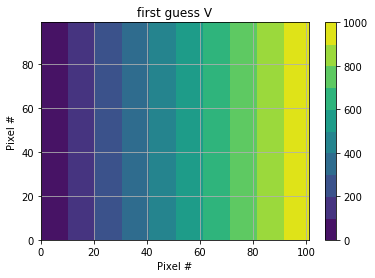

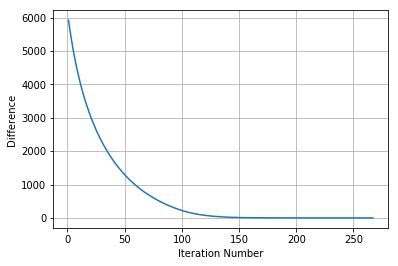

Final Difference:
0.00951580966833


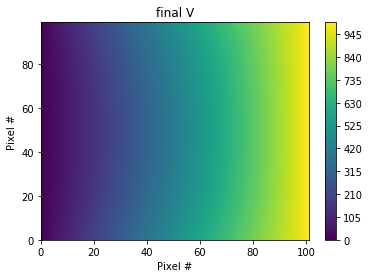

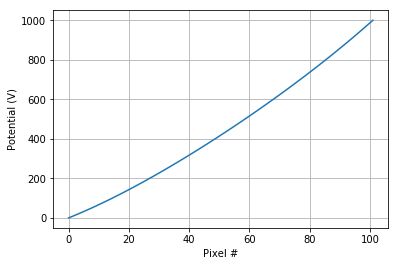

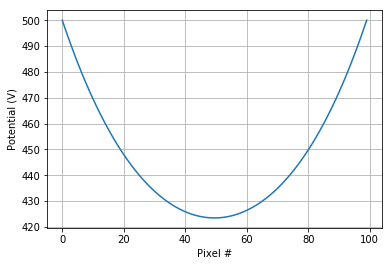

In [410]:
outer_contact_bias = 1000.0
core_contact_bias = 0.0

charge_density_zero = -1.0
charge_density_gradient = 0.1

core_length_mm = 100
core_radius_mm = 1.0

#####

V = np.zeros((N_xelements, N_yelements), dtype=float)

#####

# set up charge distribution through xtal
charge = np.zeros((N_xelements, N_yelements), dtype=float)
pixels_to_cm = 10/pixel_size_mm

for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        charge[x,y] = float(charge_density_zero + charge_density_gradient*(y/pixels_to_cm))

print(geom_map)
print(charge)


#####

# set boundary conditions and generate initial guess at solution

# initial guess at solution
for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        V[x,y] = outer_contact_bias*y / N_yelements

# outer contact
x,y = np.where(geom_map==1)
V[x,y] = outer_contact_bias

# core
x,y = np.where(geom_map==3)
V[x,y] = core_contact_bias

# passivated back face (not tested)
#x,y = np.where(geom_map==3)
#V[x,y] = 0.0

print(V)
plt.contourf(V,10,interpolation="None")
plt.grid("on")
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()
plt.title('first guess V')
plt.show()

# do the relaxation to solve

# set maximum number of iterations
max_iters = 1000

# calculate term for Coulombs per pixel / Epsilon
#e_over_e = (pixel_size_mm*pixel_size_mm) * 1e10 * 1.6e-19
e_over_e = (pixel_size_mm*pixel_size_mm/4)* (1e10*1.6e-19)/(16*8.85e-12)

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01
while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for x in range(1, N_xelements - 1):
        for y in range(1, N_yelements - 1):
                        
            # skip non-Ge pixels
            if (geom_map[x,y] != 0):
                continue
                
            # deal with reflection symmetry at x=0
            #if (x == 0):
            #    V_local_sum = (V[x,y-1] + V[x,y+1] + 2.0*V[x+1,y])
            #
            #elif (y == 0):
            #    V_local_sum = (V[x-1,y] + V[x+1,y] + 2.0*V[x,y+1])

            # all other cases
            #else:                                
            #    V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            
            # update the solution
            R[x,y] = (0.25*V_local_sum + (charge[x,y] * e_over_e)) - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]
                 
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
#plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])
plt.contourf(V, 200, vmin=0)
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()
plt.title('final V')
plt.show()

# plot some potential/field slices
yy = N_yelements / 2
xx = N_xelements / 2

# V along the longitudinal direction at rad = yy
plt.plot(V[yy,:])
plt.grid("on")
plt.xlabel("Pixel #")
plt.ylabel("Potential (V)")
plt.show()

# V along the radial direction at long = xx
plt.plot(V[:,yy])
plt.grid("on")
plt.xlabel("Pixel #")
plt.ylabel("Potential (V)")
plt.show()

###### calculate the electric field from the potential
#  - this doesn't deal with boundaries properly!
[Ex, Ey] = np.gradient(-V)
Ex = Ex * pixels_to_cm
Ey = Ey * pixels_to_cm
E = np.sqrt((Ex*Ex) + (Ey*Ey))


#Efinal = np.flipud(E)
#Efinal = np.append(Efinal, E, axis=0)

Efinal = E

plt.imshow(Efinal[:,:], interpolation="None", cmap="jet")
plt.colorbar()
plt.show()
Eslice = Efinal[xx]
plt.plot(Eslice)
plt.show()
Eslice = Efinal[yy]
plt.plot(Eslice,'o')
plt.show()
Eslice = Efinal[xx]

In [427]:
# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# continous contact
geom_map[:,0] = 3

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,0] = 3

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,0] = 3

# strip surface
geom_map[:,-1] = 2

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,-1] = 2

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,-1] = 2

# strip 
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,-1] = 1

# gap
ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4

ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4

geom_map = np.zeros((N_xelements, N_yelements), dtype=int)
geom_map[0,:] = 2
geom_map[-1,:] = 2
geom_map[:,0] = 3
geom_map[:,-1] = 1

In [428]:
# set boundary conditions 

# non-strip contacts
[ix,iy] = np.where(geom_map == 2)
W[ix,iy] = 0
#V[ix,iy] = 0

# back face
[ix,iy] = np.where(geom_map == 3)
W[ix,iy] = 0
#V[ix,iy] = 1000

# strip
[ix,iy] = np.where(geom_map == 1)
W[ix,iy] = 1
#V[ix,iy] = 0

# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):
                        
            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue
                
            # should deal with some boundary conditions...
                                   
            V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            
            # update the solution
            R[x,y] = 0.25*V_local_sum - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]
            
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1

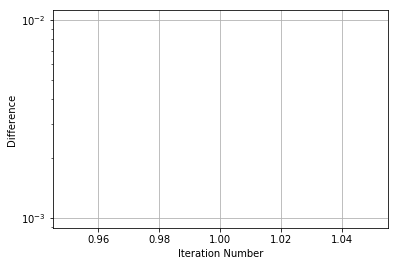

Final Difference:
0.00775370014061


In [430]:
# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

In [ ]:
# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):
                        
            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue
                
            # should deal with some boundary conditions...
                                   
            W_local_sum = (W[x+1,y] + W[x,y+1] + W[x-1,y] + W[x,y-1])
            
            # update the solution
            R[x,y] = 0.25*W_local_sum - W[x,y]
            W[x,y] = W[x,y] + w*R[x,y]
            
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1

# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

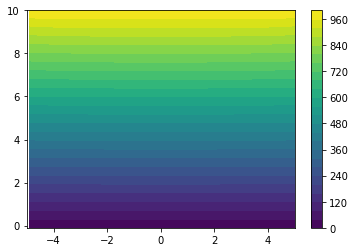

In [420]:
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, V, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()

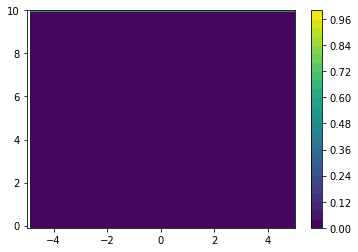

In [435]:
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, W, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()

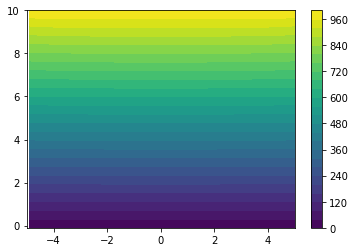

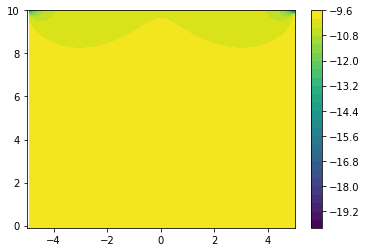

In [436]:
Varr = np.empty_like(V)
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, V, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()
plt.show()
for j in range(0, N_xelements,1):
    Vslice = V[j,:]
    Eslice= -1 * np.gradient(Vslice) #V[x_slice,:]
    Varr[j,:] = Eslice

X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, Varr, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()
plt.show()

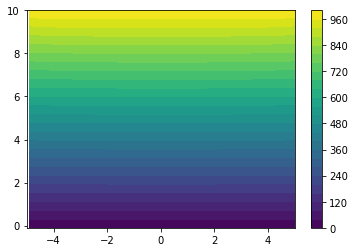

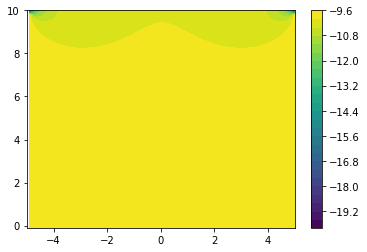

In [393]:
Varr = np.empty_like(V)
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, V, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()
plt.show()
#for j in range(0, N_xelements,1):
#    Vslice = V[j,:]
#    Eslice= -1 * np.gradient(Vslice) #V[x_slice,:]
#    Varr[j,:] = Eslice#

#X, Y = np.meshgrid(y_range, x_range)
#plt.contourf(Y,X, Varr, 30)
#plt.xlim(-detector_width_mm/2, detector_width_mm/2)
#plt.colorbar()
#plt.show()

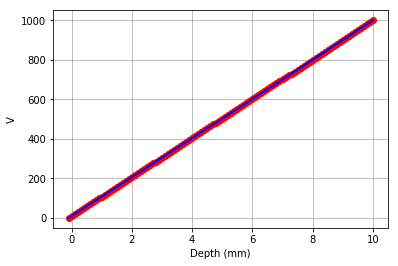

In [445]:
# take a slice through the V
x_slice = N_yelements/2
Vslice = V[x_slice,:]
Vfunc = interp1d(y_range, Vslice, kind='cubic')

plt.plot(y_range, Vfunc(y_range), 'ro',linewidth=1)
plt.plot(y_range, Vslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
#plt.xlim(0, 1.1)
#plt.ylim(0, 1000)

plt.show()

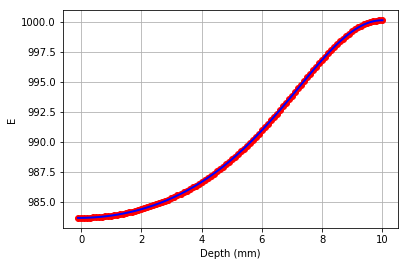

In [444]:

# take a slice through the V
x_slice = N_yelements/2
Vslice = V[x_slice,:]
Efunc = interp1d(y_range, Eslice, kind='cubic')

plt.plot(y_range, Efunc(y_range), 'ro',linewidth=1)
plt.plot(y_range, Eslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("E")
#plt.xlim(0, 1.1)
#plt.ylim(0, 1000)

plt.show()

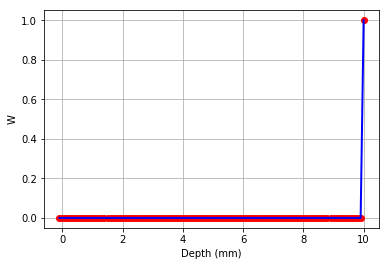

In [446]:

# take a slice through the V
x_slice = N_yelements/2
Wslice = W[x_slice,:]
Wfunc = interp1d(y_range, Wslice, kind='cubic')

plt.plot(y_range, Wfunc(y_range), 'ro',linewidth=1)
plt.plot(y_range, Wslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("W")
#plt.xlim(0, 1.1)
#plt.ylim(0, 1000)

plt.show()

102


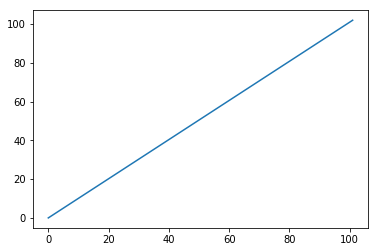

[   0.            1.00990099    2.01980198    3.02970297    4.03960396
    5.04950495    6.05940594    7.06930693    8.07920792    9.08910891
   10.0990099    11.10891089   12.11881188   13.12871287   14.13861386
   15.14851485   16.15841584   17.16831683   18.17821782   19.18811881
   20.1980198    21.20792079   22.21782178   23.22772277   24.23762376
   25.24752475   26.25742574   27.26732673   28.27722772   29.28712871
   30.2970297    31.30693069   32.31683168   33.32673267   34.33663366
   35.34653465   36.35643564   37.36633663   38.37623762   39.38613861
   40.3960396    41.40594059   42.41584158   43.42574257   44.43564356
   45.44554455   46.45544554   47.46534653   48.47524752   49.48514851
   50.4950495    51.5049505    52.51485149   53.52475248   54.53465347
   55.54455446   56.55445545   57.56435644   58.57425743   59.58415842
   60.59405941   61.6039604    62.61386139   63.62376238   64.63366337
   65.64356436   66.65346535   67.66336634   68.67326733   69.68316832
   70.

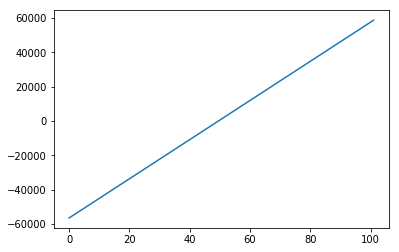

[-56488.17514124 -55347.04407898 -54205.91301673 -53064.78195447
 -51923.65089221 -50782.51982995 -49641.38876769 -48500.25770543
 -47359.12664317 -46217.99558091 -45076.86451866 -43935.7334564
 -42794.60239414 -41653.47133188 -40512.34026962 -39371.20920736
 -38230.0781451  -37088.94708284 -35947.81602059 -34806.68495833
 -33665.55389607 -32524.42283381 -31383.29177155 -30242.16070929
 -29101.02964703 -27959.89858477 -26818.76752251 -25677.63646026
 -24536.505398   -23395.37433574 -22254.24327348 -21113.11221122
 -19971.98114896 -18830.8500867  -17689.71902444 -16548.58796219
 -15407.45689993 -14266.32583767 -13125.19477541 -11984.06371315
 -10842.93265089  -9701.80158863  -8560.67052637  -7419.53946412
  -6278.40840186  -5137.2773396   -3996.14627734  -2855.01521508
  -1713.88415282   -572.75309056    568.3779717    1709.50903395
   2850.64009621   3991.77115847   5132.90222073   6274.03328299
   7415.16434525   8556.29540751   9697.42646977  10838.55753202
  11979.68859428  13120.81

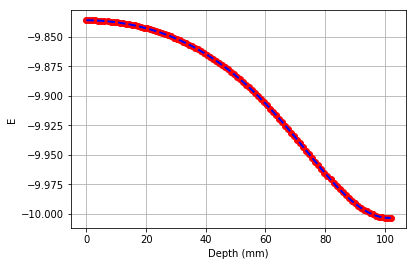

In [398]:
eps_0 = 8.85 * 10 ** (-14) 
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

yvals = np.linspace(0,N_yelements,N_yelements)
print(N_yelements)
plt.plot(yvals)
plt.show()
print(yvals)
Eslice= 1000/N_yelements + (q * rho / eps )*(yvals - 100/2)
plt.plot(Eslice)
plt.show()
print(Eslice)

Eslice=np.empty_like(Vslice)
for i in range(0, len(Vslice) -1, 1):
    Eslice[i] =  -(Vslice[i + 1] - Vslice[i])
Eslice[len(Vslice)-1] =  Eslice[len(Vslice) -2]
#Eslice = Ez
#Eslice = np.insert(Eslice, 0, Eslice[0])
y = np.linspace(0, N_yelements,N_yelements)

Efunc = interp1d(y, Eslice, kind='cubic')
plt.plot(y, Efunc(y), 'ro',linewidth=1)

#print(y)
plt.plot(y, Eslice, 'b--',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("E")
#plt.xlim(0, 16.1)
#plt.ylim(0, 1000)
plt.show()


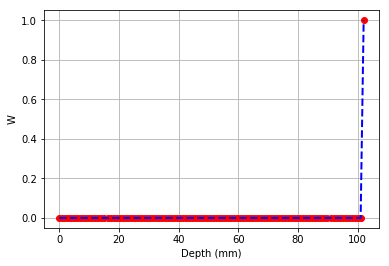

In [399]:
# take a slice through the WP

x_slice = N_xelements/2
Wslice = W[x_slice,:]

y = np.linspace(0, N_yelements,N_yelements)

Wfunc = interp1d(y, Wslice, kind='cubic')
plt.plot(y, Wfunc(y), 'ro',linewidth=1)

#print(y)
plt.plot(y, Wslice, 'b--',linewidth=2)

#plt.plot(y, Wslice, 'bo',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("W")
#plt.xlim(0, 1)
#plt.ylim(0, 0.1)
plt.show()

In [400]:
eps_0 = 8.85 * 10 ** (-14) 
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

# assume an interaction position at a given depth
depth_mm = detector_thickness_mm / 2
maxval = detector_thickness_mm / pixel_size_mm

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
print('z0: ',z0)

# number of time steps in signal
Nt = 100

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
w_e_vals = []
w_h_vals = []
zh = z0
ze = z0
zh_list
for t in range(1, Nt):
    x = zh_list[-1]
    zh = zh_list[-1]
    eslice = Efunc(x) / 10
    muh = float(hfunc(eslice))
    vh = muh * eslice
    zh = zh + 1
    #zh = np.int(zh + np.floor(vh / pixel_size_mm))

    #print(x, Eslice[x])
    #print(mue, muh)
    #print(vh)
    #print('zh', zh)

    if zh < 0:
        zh = 0
        #print('zero ', zh)
    elif zh > int(maxval):
        zh = int(maxval)
        #print('max ', zh)
    else:
        pass
    #print('zh1', zh)
    zh_list.append(zh)
    #print('=======')
    #print(zh_list)
    #print('zh2', zh)
    #x_list.append(x_list[-1] + np.floor(vh))
    if (zh== maxval) and (x!= maxval):
        dw = 1.0 - Wfunc(zh_list[t-1])
        #print('h1 ', Wfunc(zh_list[t]))
        #assert (0.9 < Wfunc(zh_list[t]) < 1.1)
        #w_h_vals.append(dw)
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
    elif (zh== maxval) and (x== maxval):
        dw = 0
        #print('h2 ',Wfunc(zh_list[t]))
        #assert (0.9 < Wfunc(zh_list[t]) < 1.1)
        #w_h_vals.append(dw)
        w_h_vals.append(0)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
    elif (zh<=N_yelements-1):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        #w_h_vals.append(dw)
        #w_h_vals.append(Wfunc(zh_list[t-1]))
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
for t in range(1, Nt):
    x = ze_list[-1]
    ze = ze_list[-1]
   # print(x)
    #print('zh0', zh)
    eslice = Efunc(x) / 10
    mue = float(efunc(eslice))
    ve = mue * eslice
    ze = ze - 1
   # print('ze ', ze)
    if ze < 0:
        ze = 0
    elif ze > int(maxval):
        ze = int(maxval)
    else:
        pass
   # print('ze1 ', ze)
    ze_list.append(ze)
    if (ze== 0) and (x!= 0):
        dw = 0- Wfunc(ze_list[t-1])
        #print('e1 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        #w_e_vals.append(dw)
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
    elif (ze== 0) and (x== 0):
        dw = 0
        #print('e2 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        w_e_vals.append(0)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
    elif (ze<=N_yelements-1):
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        #w_e_vals.append(Wfunc(zh_list[t]))
        #w_e_vals.append(Wfunc(zh_list[t-1]))
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
print(np.cumsum(Qh)[-1])
print(np.cumsum(Qe)[-1])
# electrons out of wp

Qh = Qh
Qe = - Qe
# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)

plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()


plt.plot(w_e_vals,'bo')
plt.show()
plt.plot(w_h_vals,'ro')
plt.show()


# plot
plt.plot(Qsignal_e, 'c', linewidth=1.5)
plt.plot(Qsignal_h, 'm', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)

plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()

('z0: ', 50)


ValueError: A value in x_new is below the interpolation range.

In [401]:
eps_0 = 8.85 * 10 ** (-14) # F /cm
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

# assume an interaction position at a given depth
depth_mm = detector_thickness_mm / 2
maxval = detector_thickness_mm / pixel_size_mm

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
print('z0: ',z0)

# number of time steps in signal
Nt = 200

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
w_e_vals = []
w_h_vals = []
zh = z0
ze = z0
realz_list_e = []
realz_list_h = []
realz = z0
e_slice_list_e = []
e_slice_list_h = []

for t in range(1, Nt):
    x = zh_list[-1]
    zh = zh_list[-1]
    #realz = realz_list_h[-1]
    eslice = Efunc(realz) # realz in mm or grid point 
    #muh = float(hfunc(eslice)) 
    vh = muh * eslice
    vh = float(efunc(eslice * 10)) * 10
    zh = zh + 1
    #zh = np.int(zh + np.floor(vh / pixel_size_mm))
    realz += round(float(vh),6)

    if realz < 0:
        realz = 0
    elif realz > maxval:
        realz = maxval
    realz_list_h.append(realz)
    #print(realz / 10.0)
    #print('hhh')
    #print('muh ', mue)
    #print('eslice ', eslice)
    e_slice_list_h.append(eslice)
    #print('vh ', vh)
    if zh < 0:
        zh = 0
        #print('zero ', zh)
    elif zh > int(maxval):
        zh = int(maxval)
        #print('max ', zh)
    else:
        pass
    #print('zh1', zh)
    zh_list.append(zh)

    if (zh== maxval) and (x!= maxval):
        dw = 1.0 - Wfunc(zh_list[t-1])
        #print('h1 ', Wfunc(zh_list[t]))
        #assert (0.9 < Wfunc(zh_list[t]) < 1.1)
        #w_h_vals.append(dw)
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
    elif (zh== maxval) and (x== maxval):
        dw = 0
        #print('h2 ',Wfunc(zh_list[t]))
        #assert (0.9 < Wfunc(zh_list[t]) < 1.1)
        #w_h_vals.append(dw)
        w_h_vals.append(0)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
    elif (zh<=N_yelements-1):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        #w_h_vals.append(dw)
        #w_h_vals.append(Wfunc(zh_list[t-1]))
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
        
realz = z0
for t in range(1, Nt):
    x = ze_list[-1]
    ze = ze_list[-1]
   # print(x)
    #print('zh0', zh)
    eslice = Efunc(realz)
    #mue = float(efunc(eslice))
    ve = float(efunc(eslice * 10)) * 10
    ze = ze - 1

    realz += round(float(-1 * ve),6)
    
    if realz < 0:
        realz = 0
    elif realz > maxval:
        realz = maxval
    realz_list_e.append(realz)
    #print('eee')
    #print(realz / 10.0)
    #print('mue ', mue)
    #print('eslice ', eslice)
    e_slice_list_e.append(eslice)
    #print('ve ', ve)
    
    if ze < 0:
        ze = 0
    elif ze > int(maxval):
        ze = int(maxval)
    else:
        pass
   # print('ze1 ', ze)
    ze_list.append(ze)
    if (ze== 0) and (x!= 0):
        dw = 0- Wfunc(ze_list[t-1])
        #print('e1 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        #w_e_vals.append(dw)
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
    elif (ze== 0) and (x== 0):
        dw = 0
        #print('e2 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        w_e_vals.append(0)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
    elif (ze<=N_yelements-1):
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        #w_e_vals.append(Wfunc(zh_list[t]))
        #w_e_vals.append(Wfunc(zh_list[t-1]))
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
print(np.cumsum(Qh)[-1])
print(np.cumsum(Qe)[-1])
# electrons out of wp

Qh = Qh
Qe = - Qe
# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)



plt.plot(realz_list_h,'r-')
plt.plot(realz_list_e,'b-')
plt.show()



plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()

plt.plot(realz_list_e, 'bo')
plt.show()

plt.plot(realz_list_h, 'ro')
plt.show()


print('eh ', np.mean(e_slice_list_h))
print('ee ', np.mean(e_slice_list_e))
#plt.plot(w_e_vals,'bo')
#plt.show()
#plt.plot(w_h_vals,'ro')
#plt.show()


# plot
plt.plot(Qsignal_e, 'c', linewidth=1.5)
plt.plot(Qsignal_h, 'm', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)

plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()

('z0: ', 50)


NameError: name 'muh' is not defined

('z0: ', 80)
0.5662
-0.4338


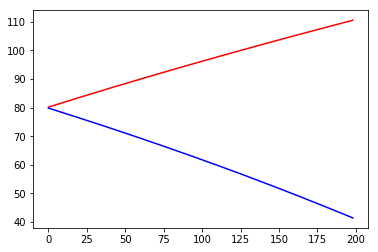

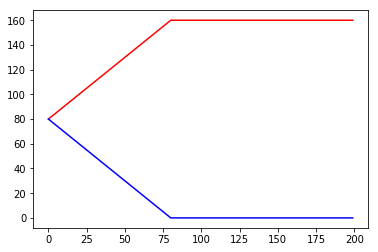

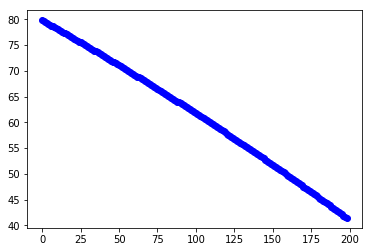

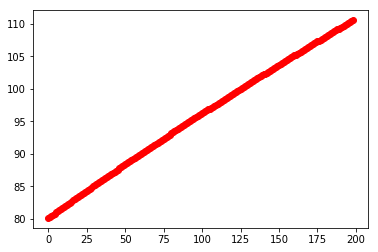

('eh ', 5.129911621794693)
('ee ', 6.7183606082269796)


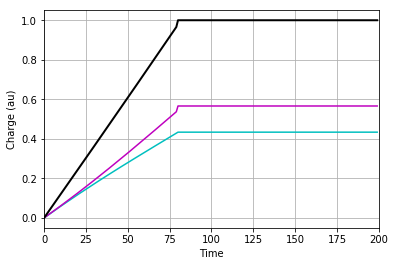

In [239]:
eps_0 = 8.85 * 10 ** (-14) # F /cm
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

# assume an interaction position at a given depth
depth_mm = detector_thickness_mm / 2
maxval = detector_thickness_mm / pixel_size_mm

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
print('z0: ',z0)

# number of time steps in signal
Nt = 200

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
w_e_vals = []
w_h_vals = []
zh = z0
ze = z0
realz_list_e = []
realz_list_h = []
realz = z0
e_slice_list_e = []
e_slice_list_h = []
for t in range(1, Nt):
    x = zh_list[-1]
    zh = zh_list[-1]
    #realz = realz_list_h[-1]
    eslice = Efunc(realz) # realz in mm or grid point 
    #muh = float(hfunc(eslice)) 
    vh = muh * eslice
    vh = float(efunc(eslice * 10)) * 10
    zh = zh + 1
    #zh = np.int(zh + np.floor(vh / pixel_size_mm))
    realz += round(float(vh),6)

    if realz < 0:
        realz = 0
    elif realz > maxval:
        realz = maxval
    realz_list_h.append(realz)
    #print(realz / 10.0)
    #print('hhh')
    #print('muh ', mue)
    #print('eslice ', eslice)
    e_slice_list_h.append(eslice)
    #print('vh ', vh)
    if zh < 0:
        zh = 0
        #print('zero ', zh)
    elif zh > int(maxval):
        zh = int(maxval)
        #print('max ', zh)
    else:
        pass
    #print('zh1', zh)
    zh_list.append(zh)

    if (zh== maxval) and (x!= maxval):
        dw = 1.0 - Wfunc(zh_list[t-1])
        #print('h1 ', Wfunc(zh_list[t]))
        #assert (0.9 < Wfunc(zh_list[t]) < 1.1)
        #w_h_vals.append(dw)
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
    elif (zh== maxval) and (x== maxval):
        dw = 0
        #print('h2 ',Wfunc(zh_list[t]))
        #assert (0.9 < Wfunc(zh_list[t]) < 1.1)
        #w_h_vals.append(dw)
        w_h_vals.append(0)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
    elif (zh<=N_yelements-1):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        #w_h_vals.append(dw)
        #w_h_vals.append(Wfunc(zh_list[t-1]))
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
        
realz = z0
for t in range(1, Nt):
    x = ze_list[-1]
    ze = ze_list[-1]
   # print(x)
    #print('zh0', zh)
    eslice = Efunc(realz)
    #mue = float(efunc(eslice))
    ve = float(efunc(eslice * 10)) * 10
    ze = ze - 1

    realz += round(float(-1 * ve),6)
    
    if realz < 0:
        realz = 0
    elif realz > maxval:
        realz = maxval
    realz_list_e.append(realz)
    #print('eee')
    #print(realz / 10.0)
    #print('mue ', mue)
    #print('eslice ', eslice)
    e_slice_list_e.append(eslice)
    #print('ve ', ve)
    
    if ze < 0:
        ze = 0
    elif ze > int(maxval):
        ze = int(maxval)
    else:
        pass
   # print('ze1 ', ze)
    ze_list.append(ze)
    if (ze== 0) and (x!= 0):
        dw = 0- Wfunc(ze_list[t-1])
        #print('e1 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        #w_e_vals.append(dw)
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
    elif (ze== 0) and (x== 0):
        dw = 0
        #print('e2 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        w_e_vals.append(0)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
    elif (ze<=N_yelements-1):
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        #w_e_vals.append(Wfunc(zh_list[t]))
        #w_e_vals.append(Wfunc(zh_list[t-1]))
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
print(np.cumsum(Qh)[-1])
print(np.cumsum(Qe)[-1])
# electrons out of wp

Qh = Qh
Qe = - Qe
# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)



plt.plot(realz_list_h,'r-')
plt.plot(realz_list_e,'b-')
plt.show()



plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()

plt.plot(realz_list_e, 'bo')
plt.show()

plt.plot(realz_list_h, 'ro')
plt.show()


print('eh ', np.mean(e_slice_list_h))
print('ee ', np.mean(e_slice_list_e))
#plt.plot(w_e_vals,'bo')
#plt.show()
#plt.plot(w_h_vals,'ro')
#plt.show()


# plot
plt.plot(Qsignal_e, 'c', linewidth=1.5)
plt.plot(Qsignal_h, 'm', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)

plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()

('z0: ', 80)


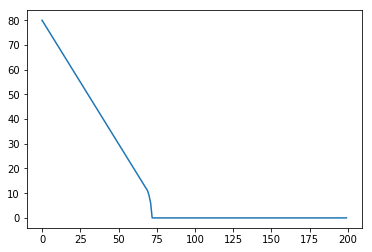

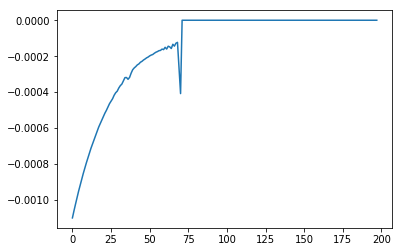

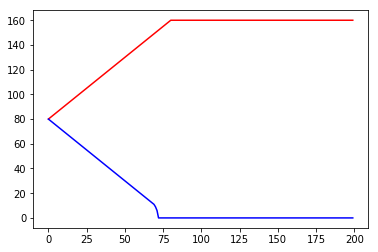

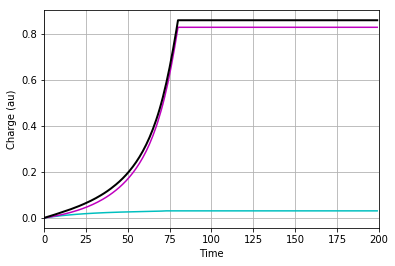

In [36]:
eps_0 = 8.85 * 10 ** (-14) 
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

# assume an interaction position at a given depth
depth_mm = 8

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
print('z0: ',z0)
maxval = 16.0 / pixel_size_mm

# number of time steps in signal
Nt = 200

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

realz = z0

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
x_list = []
zh = z0
ze = z0
w_e_vals = []
w_h_vals = []
for t in range(1, Nt):
    x = zh_list[-1]
    eslice = Efunc(x)
    muh = float(hfunc(eslice))
    vh = muh * eslice
    zh = np.int(zh + np.floor(vh / pixel_size_mm))
    zh = zh +1
    #print(x, Eslice[x])
    #print(mue, muh)
    #print(vh)
    #print('zh', zh)

    if zh <= 0:
        zh = 0
    elif zh >= int(maxval):
        zh = int(maxval)
    else:
        pass
    zh_list.append(zh)
    if (zh== maxval) and (x== maxval):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        Qh[t] = round(1.0*dw,4)
    elif (zh<=N_yelements-1):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        Qh[t] = round(1.0*dw,4)  

# electrons out of wp
t = 0
for t in range(1, Nt):
    x = ze_list[-1]
    eslice = Efunc(x)
    mue = float(efunc(eslice))
    ve = mue * eslice
    ze = np.int(ze - np.floor(ve / pixel_size_mm))
    ze = ze -1
    if ze <= 0:
        ze = 0
    elif ze >= int(maxval):
        ze = int(maxval)
    else:
        pass
    ze_list.append(ze)
    
    if (ze== 0)and( x!= 0):
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        Qe[t] = round(1.0*dw,4)
    elif (ze== 0)and( x== 0):
        dw = 0.0
        w_e_vals.append(dw)
        Qe[t] = -1 * round(1.0*dw,2)
    elif (ze<=N_yelements-1):
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)  
        
plt.plot(ze_list)
plt.show()
plt.plot(w_e_vals)
plt.show()

Qh = Qh
Qe = - Qe
# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)

plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()

# plot
plt.plot(Qsignal_e, 'c', linewidth=1.5)
plt.plot(Qsignal_h, 'm', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)

plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()

In [ ]:
Qsignal_h_arr = np.zeros((17,200), dtype=float)
Qsignal_e_arr = np.zeros((17,200), dtype=float)
Qsignal_arr = np.zeros((17,200), dtype=float)

# assume an interaction position at a given depth
for i in range(12,13,1):
    depth_mm = float(i)

    # assume an interaction position at a given depth

    z0 = np.int(np.floor(depth_mm / pixel_size_mm))
    print('z0: ',z0)
    maxval = 16.0 / pixel_size_mm

    # number of time steps in signal
    Nt = 200

    # arrays which will store the induced charge signals
    Qh = np.zeros(Nt, dtype=float)
    Qe = np.zeros(Nt, dtype=float)

    # starting positions for electrons and holes
    zh_list = []
    ze_list = []
    zh_list.append(z0)
    ze_list.append(z0)
    # holes into wp
    t = 0
    x_list = []
    zh = z0
    ze = z0
    w_e_vals = []
    w_h_vals = []
    for t in range(1, Nt):
        x = zh_list[-1]
        eslice = Efunc(x)
        muh = float(hfunc(eslice))
        #vh = muh * eslice
        #zh = np.int(zh + np.floor(vh / pixel_size_mm))
        zh = zh + 1

        #print(x, Eslice[x])
        #print(mue, muh)
        #print(vh)
        #print('zh', zh)

        if zh < 0:
            zh = 0
        elif zh > int(maxval):
            zh = int(maxval)
        else:
            pass
        zh_list.append(zh)
        #x_list.append(x_list[-1] + np.floor(vh))
        if (ze== 0)and( zh_list[-1] != 0):
            #print('max')
            #print(zh_list[t])
            #print(zh_list[t-1])
            dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
            w_e_vals.append(1.0)
            Qh[t] = round(1.0*dw,10)
            print('rrhole')
            print(dw)
            print(np.cumsum(Qh)[-1])
           # continue
        elif (zh== maxval) and (x== maxval):
            #print('max')
            #print(zh_list[t])
            #print(zh_list[t-1])
            dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
            w_e_vals.append(1.0)
            Qh[t] = round(1.0*dw,10)
            #print('hole')
            #print(dw)
            #print(np.cumsum(Qh)[-1])
           # continue
        elif (zh<=N_yelements-1):
            dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
            w_e_vals.append(Wfunc(zh_list[t]))
            w_e_vals.append(Wfunc(zh_list[t-1]))
            Qh[t] = round(1.0*dw,10)  
            print('nmh')
            print(dw)
            print(np.cumsum(Qh)[-1])


    # electrons out of wp
    t = 0
    for t in range(1, Nt):
        x = ze_list[-1]
        eslice = Efunc(x)
        mue = float(efunc(eslice))
        ve = mue * eslice
        #ze = np.int(ze - np.floor(ve / pixel_size_mm))
        ze = ze -1
        
        if ze <= 0:
            ze = 0
        elif ze >= int(maxval):
            ze = int(maxval)
        else:
            pass
        ze_list.append(ze)
        #x_list.append(x_list[-1] + np.floor(vh))
        if (ze== 0)and( zh_list[-1] != 0):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(1.0)
            Qe[t] = -1 * round(1.0*dw,10)
            print('min')
            print(ze_list[t])
            print(ze_list[t-1])
            print(dw)
            print(np.cumsum(Qe)[-1])
           # continue
        elif (ze== 0)and( x== 0):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(1.0)
            Qe[t] = -1 * round(1.0*dw,10)
            #print('miny')
            #print(ze_list[t])
            #print(ze_list[t-1])
            #print(dw)
            #print('qe ', np.cumsum(Qe)[-1])
           # continue
        elif (ze<=N_yelements-1):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(Wfunc(ze_list[t]))
            w_e_vals.append(Wfunc(ze_list[t-1]))
            Qe[t] = -1 * round(1.0*dw,10)    
            print('nm')
            print(dw)
            print('qe ',np.cumsum(Qe)[-1])
            ###
        
    #Qh = Qh
    #Qe = -1 * Qe
    # take cumulative sums
    Qsignal_h = np.cumsum(Qh)
    Qsignal_e = np.cumsum(Qe)
    Qsignal = np.cumsum(Qe + Qh)
    
    Qsignal_h_arr[i] = Qsignal_h
    Qsignal_e_arr[i] = Qsignal_e
    Qsignal_arr[i] = Qsignal

    plt.plot(zh_list,'r-')
    plt.plot(ze_list,'b-')
    plt.show()

    # plot
    plt.plot(Qsignal_e, 'c-', linewidth=1.5)
    plt.plot(Qsignal_h, 'm-', linewidth=1.5)
    plt.plot(Qsignal, 'k-', linewidth=2)

    plt.grid("on")
    #plt.ylim(0,1)
    plt.xlim(0, Nt)
    #plt.tick_params(labelbottom="off")
    plt.xlabel("Time")
    plt.ylabel("Charge (au)")
    #plt.legend()
    plt.show()
    
    

In [ ]:
chi2 = []
for i in range(0, 10,1):
    chix = np.sum(Qsignal_arr[i] - Qsignal_arr[0])
    print(i)
    plt.plot(Qsignal_arr[i])
    plt.plot(Qsignal_arr[0])
    plt.show()
    chi2.append(chix)

In [ ]:
plt.plot(chi2)
plt.show()

In [ ]:
ristime_diffs = []

for i in range(0, 17):
    t50_e = 0
    t50_h = 0
    
    Qsignal = Qsignal_arr[i]
    
    high = 0
    low = 0
    
    #plt.plot(Qsignal_h)
    #plt.plot(Qsignal_e)
    #plt.show()
    
    
    for j in range(0, len(Qsignal)):
        #print(j)
        #print(Qsignal_e[j])
        #print(0.5*np.amax(Qsignal_e))
        if Qsignal[j] < 0.5*np.amax(Qsignal):
            low = j
        if Qsignal[j] > 0.5*np.amax(Qsignal):
            high = j
            break

    t50_1 = (high + low) / 2.0  # ns
    
    ristime_diffs.append(t50_1 )#- t50_2)
    

In [ ]:
plt.plot(ristime_diffs,'-')
plt.show()

Final Difference:
0.00919607324721
Final Difference:
0.00989965337995


IndexError: index 125 is out of bounds for axis 0 with size 86

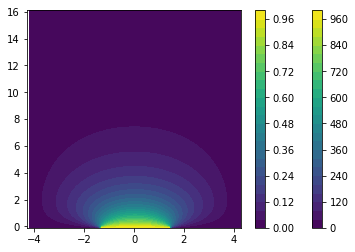

In [25]:
# set some detector parameters
strip_width_mm = 2.8
strip_gap_mm = 0.2
detector_thickness_mm = 16.0 #16.0
pixel_size_mm = 0.1

# set detector width to n*pitch where n is an odd number
detector_width_mm = (3*strip_width_mm+strip_gap_mm)


# In[204]:


# build some grids
x_range = np.arange(-detector_width_mm/2 + pixel_size_mm, detector_width_mm/2 + pixel_size_mm, pixel_size_mm)
y_range = np.arange(-pixel_size_mm, detector_thickness_mm + pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)
W = np.zeros((N_xelements, N_yelements), dtype=float)
E = np.zeros((N_xelements, N_yelements), dtype=float)


# In[205]:


# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# continous contact
geom_map[:,0] = 3

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,0] = 3

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,0] = 3

# strip surface
geom_map[:,-1] = 2

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,-1] = 2

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,-1] = 2

# strip
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,0] = 1

# gap
ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4

ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4


# In[206]:


# set boundary conditions

# non-strip contacts
[ix,iy] = np.where(geom_map == 2)
W[ix,iy] = 0
V[ix,iy] = 0

# back face
[ix,iy] = np.where(geom_map == 3)
W[ix,iy] = 0
V[ix,iy] = 1000

# strip
[ix,iy] = np.where(geom_map == 1)
W[ix,iy] = 1
V[ix,iy] = 0


# In[207]:


# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):

    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):

            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue

            # should deal with some boundary conditions...

            V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])

            # update the solution
            R[x,y] = 0.25*V_local_sum - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]

    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid

    # update iteration counter
    iterr+=1


# In[208]:


# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.savefig('finaldiff1.pdf')
plt.cla()
plt.clf()
#plt.show()

# also print the final difference
print("Final Difference:")
print(resid_store[-1])


# In[ ]:





# In[210]:


# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):

    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):

            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue

            # should deal with some boundary conditions...

            W_local_sum = (W[x+1,y] + W[x,y+1] + W[x-1,y] + W[x,y-1])

            # update the solution
            R[x,y] = 0.25*W_local_sum - W[x,y]
            W[x,y] = W[x,y] + w*R[x,y]

    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid

    # update iteration counter
    iterr+=1


# In[211]:


# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.savefig('diff2.pdf')
plt.cla()
plt.clf()
#plt.show()

# also print the final difference
print("Final Difference:")
print(resid_store[-1])


# In[212]:


X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, V, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()


# In[213]:


X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, W, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()


# In[254]:


# take a slice through the V
x_slice = 125
Vslice = V[x_slice,:]

plt.plot(y_range, Vslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
plt.xlim(0, 16.1)
plt.ylim(0, 1000)
plt.show()

# take a slice through the V
x_slice = 125
Vslice = V[x_slice,:]
Vfunc = interp1d(y_range, Vslice, kind='cubic')

plt.plot(y_range, Vslice, 'b-',linewidth=2)
plt.plot(y_range, Vfunc(y_range), 'ro',linewidth=1)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
plt.xlim(0, 1.1)
plt.ylim(0, 1000)

plt.show()


# In[297]:


#print(len(Eslice))
#print(len(Vslice))
#print(len(y))
# take a slice through the WP

x_slice = N_xelements/2
Eslice = -1 * np.gradient(Vslice) #V[x_slice,:]
#Eslice = np.insert(Eslice, 0, Eslice[0])
y = np.linspace(0, N_yelements,N_yelements)

Efunc = interp1d(y, Eslice, kind='cubic')
plt.plot(y, Efunc(y), 'ro',linewidth=1)

#print(y)
plt.plot(y, Eslice, 'b--',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
#plt.xlim(0, 16.1)
#plt.ylim(0, 1000)
plt.show()


# In[298]:


# take a slice through the WP

x_slice = N_xelements/2
Wslice = W[x_slice,:]

y = np.linspace(0, N_yelements,N_yelements)

Wfunc = interp1d(y, Wslice, kind='cubic')
plt.plot(y, Wfunc(y), 'ro',linewidth=1)

#print(y)
plt.plot(y, Wslice, 'b--',linewidth=2)

#plt.plot(y, Wslice, 'bo',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("W")
#plt.xlim(0, 1)
#plt.ylim(0, 0.1)
plt.show()


# In[322]:


eps_0 = 8.85 * 10 ** (-14)
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

# assume an interaction position at a given depth
depth_mm = 0.2

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
print('z0: ',z0)
maxval = 1.0 / pixel_size_mm

# number of time steps in signal
Nt = 200

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
x_list = []
zh = z0
ze = z0
w_e_vals = []
w_h_vals = []
for t in range(1, Nt):
    x = zh_list[-1]
    eslice = Efunc(x)
    muh = float(hfunc(eslice))
    vh = muh * eslice
    zh = np.int(zh + np.floor(vh / pixel_size_mm))

    #print(x, Eslice[x])
    #print(mue, muh)
    #print(vh)
    #print('zh', zh)

    if zh <= 0:
        zh = 0
    if zh >= int(maxval):
        zh = int(maxval)
    zh_list.append(zh)
    #x_list.append(x_list[-1] + np.floor(vh))
    if (zh== maxval) and (x== maxval):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        w_h_vals.append(1.0)
        Qh[t] = round(1.0*dw,4)
    elif (zh<=N_yelements-1):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        w_h_vals.append(Wfunc(zh_list[t]))
        w_h_vals.append(Wfunc(zh_list[t-1]))
        Qh[t] = round(1.0*dw,4)

# electrons out of wp
t = 0
for t in range(1, Nt):
    x = ze_list[-1]
    eslice = Efunc(x)
    mue = float(efunc(eslice))
    ve = mue * eslice
    ze = np.int(ze - np.floor(ve / pixel_size_mm))

    if ze <= 0:
        ze = 0
    if ze >= int(maxval):
        ze = int(maxval)
    ze_list.append(ze)
    #x_list.append(x_list[-1] + np.floor(vh))
    if (ze== 0)and( x!= 0):
        #print('min')
        #print(ze_list[t])
        #print(ze_list[t-1])
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        w_e_vals.append(1.0)
        Qe[t] = round(1.0*dw,4)
        #print(dw)
        #print(np.cumsum(Qe)[-1])
       # continue
    elif (ze== 0)and( x== 0):
        dw = 0.0
        w_e_vals.append(1.0)
        Qe[t] = -1 * round(1.0*dw,2)

    elif (ze<=N_yelements-1):
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        w_e_vals.append(Wfunc(ze_list[t]))
        w_e_vals.append(Wfunc(ze_list[t-1]))
        Qe[t] = round(1.0*dw,4)

Qh = Qh
Qe = - Qe
# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)

plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()

# plot
plt.plot(Qsignal_e, 'c', linewidth=1.5)
plt.plot(Qsignal_h, 'm', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)

plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()


# In[333]:


Qsignal_h_arr = np.zeros((17,200), dtype=float)
Qsignal_e_arr = np.zeros((17,200), dtype=float)
Qsignal_arr = np.zeros((17,200), dtype=float)

# assume an interaction position at a given depth
for i in range(0,10,1):
    depth_mm = float(i / 10.0)

    # assume an interaction position at a given depth

    z0 = np.int(np.floor(depth_mm / pixel_size_mm))
    print('z0: ',z0)
    maxval = 1.0 / pixel_size_mm

    # number of time steps in signal
    Nt = 200

    # arrays which will store the induced charge signals
    Qh = np.zeros(Nt, dtype=float)
    Qe = np.zeros(Nt, dtype=float)

    # starting positions for electrons and holes
    zh_list = []
    ze_list = []
    zh_list.append(z0)
    ze_list.append(z0)
    # holes into wp
    t = 0
    x_list = []
    zh = z0
    ze = z0
    w_e_vals = []
    w_h_vals = []
    for t in range(1, Nt):
        x = zh_list[-1]
        eslice = Efunc(x)
        muh = float(hfunc(eslice))
        vh = muh * eslice
        zh = np.int(zh + np.floor(vh / pixel_size_mm))

        #print(x, Eslice[x])
        #print(mue, muh)
        #print(vh)
        #print('zh', zh)

        if zh <= 0:
            zh = 0
        if zh >= int(maxval):
            zh = int(maxval)
        zh_list.append(zh)
        #x_list.append(x_list[-1] + np.floor(vh))
        if (zh== maxval) and (x== maxval):
            #print('max')
            #print(zh_list[t])
            #print(zh_list[t-1])
            dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
            w_e_vals.append(1.0)
            Qh[t] = round(1.0*dw,2)
            #print(dw)
            #print(np.cumsum(Qh)[-1])
           # continue
        elif (zh<=N_yelements-1):
            dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
            w_e_vals.append(Wfunc(zh_list[t]))
            w_e_vals.append(Wfunc(zh_list[t-1]))
            Qh[t] = round(1.0*dw,2)
            #print('nm')
            #print(dw)
            #print(np.cumsum(Qh)[-1])


    # electrons out of wp
    t = 0
    for t in range(1, Nt):
        x = ze_list[-1]
        eslice = Efunc(x)
        mue = float(efunc(eslice))
        ve = mue * eslice
        ze = np.int(ze - np.floor(ve / pixel_size_mm))


        if ze <= 0:
            ze = 0
        if ze >= int(maxval):
            ze = int(maxval)
        ze_list.append(ze)
        #x_list.append(x_list[-1] + np.floor(vh))
        if (ze== 0)and( x!= 0):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(1.0)
            Qe[t] = -1 * round(1.0*dw,2)
            #print('min')
            #print(ze_list[t])
            #print(ze_list[t-1])
            #print(dw)
            #print(np.cumsum(Qe)[-1])
           # continue
        elif (ze== 0)and( x== 0):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(1.0)
            Qe[t] = -1 * round(1.0*dw,2)
            #print('miny')
            #print(ze_list[t])
            #print(ze_list[t-1])
            #print(dw)
            #print(np.cumsum(Qe)[-1])
           # continue
        elif (zh<=N_yelements-1):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(Wfunc(ze_list[t]))
            w_e_vals.append(Wfunc(ze_list[t-1]))
            Qe[t] = -1 * round(1.0*dw,2)
            #print('nm')
            #print(dw)
            #print(np.cumsum(Qe)[-1])
            ###

    #Qh = Qh
    #Qe = -1 * Qe
    # take cumulative sums
    Qsignal_h = np.cumsum(Qh)
    Qsignal_e = np.cumsum(Qe)
    Qsignal = np.cumsum(Qe + Qh)

    Qsignal_h_arr[i] = Qsignal_h
    Qsignal_e_arr[i] = Qsignal_e
    Qsignal_arr[i] = Qsignal

    plt.plot(zh_list,'r-')
    plt.plot(ze_list,'b-')
    plt.show()

    # plot
    plt.plot(Qsignal_e, 'c-', linewidth=1.5)
    plt.plot(Qsignal_h, 'm-', linewidth=1.5)
    plt.plot(Qsignal, 'k-', linewidth=2)

    plt.grid("on")
    #plt.ylim(0,1)
    plt.xlim(0, Nt)
    #plt.tick_params(labelbottom="off")
    plt.xlabel("Time")
    plt.ylabel("Charge (au)")
    #plt.legend()
    plt.show()

